In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 05/06/2021

    Code description :
    __________________
    Generates low-rank matrix and recover it 
    by solving an inverse problem from rank-one projections.

"""
import matplotlib.pyplot as plt
import numpy as np
import time
from pyunlocbox import functions, solvers

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),3),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from IHT_ROP import IHT_ROP
from functions import snr
from graphics import *
set_plot_params() # Set the plot params

# 1) $\boldsymbol{X}$ and $\boldsymbol{\alpha}$ are real
Create low-rank matrix $X$

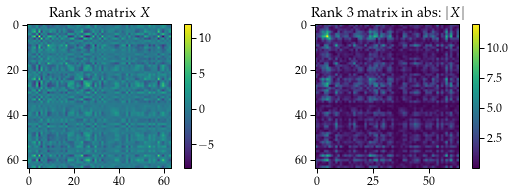

In [2]:
r = 3 # rank of X
N=64 # size of X
x = np.random.randn(N,r)
X = x@x.T

fig=plt.figure(figsize=(8,3))
axs=subplot_axs(fig, 1,2)
im0=axs[0].imshow(X, cmap='viridis')
im1=axs[1].imshow(np.abs(X), cmap='viridis')
axs[0].set_title('Rank {} matrix $X$'.format(r) )
axs[1].set_title('Rank {} matrix in abs: $|X|$'.format(r) )
fig.colorbar(im0,ax=axs[0])
fig.colorbar(im1,ax=axs[1])
plt.show()

Generate random observation vectors $\mathbf{\alpha}$

In [3]:
M = 3000 # Number of ROP of F

a_ij = np.random.randn(M,N)/np.sqrt(2)

"Check alpha's norm"
print('The norm of this alpha_i is {:.2f}'.format(np.linalg.norm(a_ij[20,:])))
print('a_ij.shape= ', a_ij.shape)

The norm of this alpha_i is 5.37
a_ij.shape=  (3000, 64)


## Reconstruction
Solving $\hat{X} = \text{argmin}_{X}~\lVert X \rVert_{_*} \text{s.t.} \lVert \mathcal{A}(X)-y \rVert_2 \le \epsilon$ using Douglas-Rashford with $f(X) = \lVert X \rVert_{_*}$ and $g(X) = \mathcal i_{\mathcal B_2(0,\epsilon)}(\mathcal{A}(X)-y)$

---

Consider the problem
$$
    \text{min}~f(x)+g(x)
$$
where, $f, g: \mathbb R^n \rightarrow \mathbb R U \{ +\infty \}$ are closed proper convex functions. Then the \emph{Douglas-Rachford} splitting is 
\begin{align*}
    x^{k+1} &:= \text{prox}_{\lambda f}~(z^k-u^k) \\
    z^{k+1} &:= \text{prox}_{\lambda g}~(x^{k+1}+u^k) \\
    u^{k+1} &:= u^k+x^{k+1} - z^{k+1}
\end{align*}

---

First let us create the observations

In [4]:
# Operators for PyUnLocBox (with a single input)
A_op = lambda Xin: np.real(A(Xin, a_ij))
At_op = lambda Xin: A_star2(Xin, a_ij)

# Evaluating the norm of A_op with the power method
nu_rop = eval_nu(X, A_op, At_op, nb_iter=50)*1.01

# Observations
y = A_op(X)
y_nrj = np.linalg.norm(y,2)

Now analyse the proximal operator of our function.

Solution found after 1 iterations:
    objective function f(sol) = 3.306238e+02
    stopping criterion: MAXIT


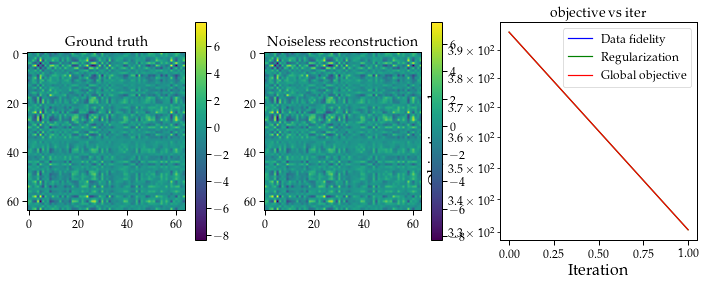

SNR: 29.49 dB
Time elapsed: 29.67s


In [5]:
tic = time.time()

"/!\ is_hermitian has been manually added in the PyUnLocBox toolbox to be put in the SVD decomposition. If you don't have access to this modification, simply remove this input "
f1 = functions.norm_nuclear( is_hermitian=True) 
f2 = functions.proj_b2(epsilon=1e-2*y_nrj, y=y, A=A_op, At=At_op, tight=False, nu=nu_rop) # tight=False => A*A != a.Id
f2.verbosity = 'HIGH' # Avoid printing the result at each iteration

solver = solvers.douglas_rachford(step=1e-2)
x0 = At_op(y)

maxiter=1
Xhat_data = solvers.solve([f2, f1], x0, solver, rtol=1e-5, maxit=maxiter)
Xhat = Xhat_data['sol']
show_rec2D(rmdiag(X), Xhat, Xhat_data['objective'])

toc = time.time()
print('Time elapsed: {:.2f}s'.format(toc-tic))

Note: we observe the reconstruction contains a diag as it minimizes the rank

Solving $\hat{X} = \text{argmin}_{X}~\lVert X \rVert_{_*}~\text{s.t. } X \succcurlyeq 0 \text{ and } \lVert \mathcal{A}(X)-y \rVert_2 \le \epsilon$ using Generalized forward-backward

Note : with Generalized forward-backward, at least one function must be convex and smooth. As any norm is convex, the nuclear norm is convex as well.

Solution found after 2 iterations:
    objective function f(sol) = 2.039740e+02
    stopping criterion: MAXIT


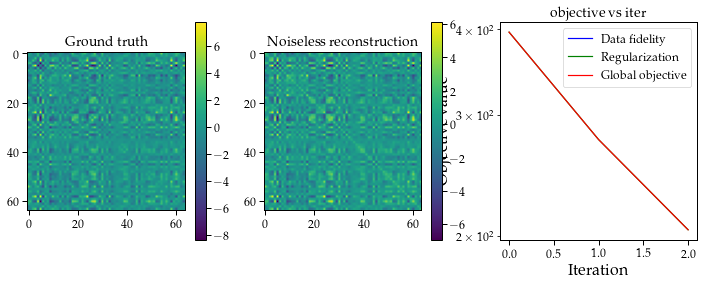

SNR: 12.58 dB
3.500737894013284e-12


In [6]:
f1 = functions.norm_nuclear()
f2 = functions.proj_spsd()
f3 = functions.proj_b2(epsilon=1e-2*y_nrj, y=y, A=A_op, At=At_op, tight=False, nu=nu_rop) # tight=False => A*A != a.Id
f3.verbosity = 'LOW' # Avoid printing the result at each iteration

solver = solvers.generalized_forward_backward(step=1e-2)
x0 = At_op(y) #, dtype=complex) 

maxiter=2
Xhat_data = solvers.solve([f2, f1, f3], x0, solver, rtol=1e-5, maxit=maxiter)
Xhat = Xhat_data['sol']
show_rec2D(rmdiag(X), Xhat, Xhat_data['objective'])

# Is sol symmetric?
print( np.sum(np.abs(Xhat-Xhat.T) ) )

## Testing Iterative Hard Thresholding (IHT) algorithm from Simon Foucard
$\boldsymbol{X}_{n+1} = H_s \left( \boldsymbol{X}_n + \mu_n H_t \left( \mathcal{A}^* \text{sgn}(\boldsymbol{y}-\mathcal{A}\boldsymbol{X_n}) \right) \right)$

Tolerance reached: |X_n1-X_n|=1e-08


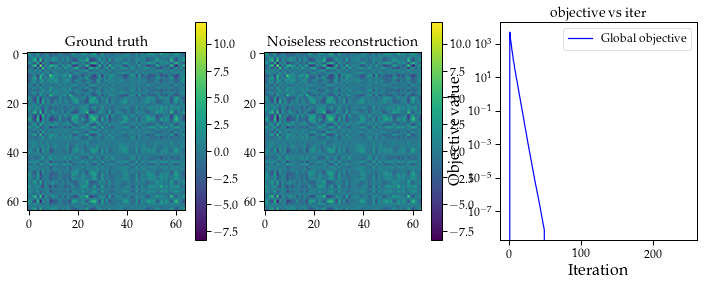

SNR: 240.06 dB
Elapsed time: 5.29s


In [7]:
gamma = 0.99
# s = 100*gamma**4*r
# t = 800*gamma**12*s
s= int(r)
t= int(r)

Xn = np.zeros(X.shape) # initial condition
maxit = 250
tol = 1e-8

tic = time.time()
Xn, diffs = IHT_ROP(Xn,y,a_ij,maxit=maxit, gamma=gamma, s=s, t=t, tol=tol)
show_rec2D(X, Xn, diffs)

tac = time.time()
print('Elapsed time: {:.2f}s'.format(tac-tic))

# 2) $\boldsymbol{X}$ and $\boldsymbol{\alpha}$ are complex
Create low-rank matrix $X$

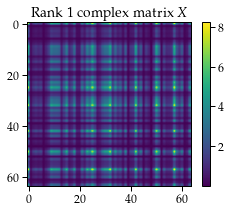

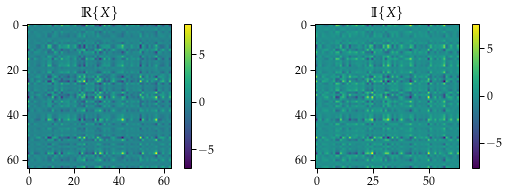

Check X is hermitian : 0.0


In [8]:
r = 1
N=64
x = (np.random.randn(N,r) + 1j*np.random.randn(N,r))
X = x@x.T.conj()

plt.figure(figsize=(4,3))
plt.imshow(np.abs(X), cmap='viridis')
plt.title('Rank {} complex matrix $X$'.format(r) )
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(8,3))
axs = subplot_axs(fig, 1, 2)
im0 = axs[0].imshow(np.real(X))
im1 = axs[1].imshow(np.imag(X))
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
axs[0].set_title('$\mathbb{R}\{X\}$')
axs[1].set_title('$\mathbb{I}\{X\}$')
plt.show()

print('Check X is hermitian : {}'.format(np.sum(np.abs(X-X.T.conj()))))

Generate random observation vectors $\mathbf{\alpha}$

In [9]:
M = 3000 # Number of ROP of F

a_ij = (np.random.randn(M,N)+1j*np.random.randn(M,N))/np.sqrt(M)

## Reconstruction
Solving $\hat{X} = \text{argmin}_{X}~\lVert X \rVert_{_*}~\text{s.t.}~\lVert \mathcal{A}(X)-y \rVert_2 \le \epsilon$ using Douglas-Rashford

First create the operator and observations

In [10]:
# Operators for PyUnLocBox (with a single input)
A_op = lambda Xin: A(Xin, a_ij, diagless=True)
At_op = lambda Xin: A_star2(Xin, a_ij, diagless=True)

# Evaluating the norm of A_op with the power method
nu_rop = eval_nu(X, A_op, At_op, nb_iter=50)*1.01

# Observations
y = A_op(X)
y_nrj = np.linalg.norm(y,2)

Solution found after 50 iterations:
    objective function f(sol) = 1.105485e+02
    stopping criterion: MAXIT


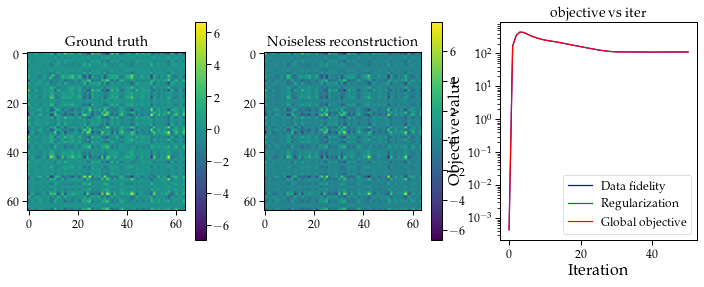

SNR: 14.34 dB
Time elapsed: 199.74521827697754
SNR: 27.23 dB


In [11]:
tic=time.time()

f1 = functions.norm_nuclear(is_hermitian=True)
f2 = functions.proj_b2(epsilon=4e-2*y_nrj, y=y, A=A_op, At=At_op, tight=False, nu=nu_rop) # tight=False => A*A != a.Id
f2.verbosity = 'HIGH' # Avoid printing the result at each iteration

solver = solvers.douglas_rachford() #step=1e-2)
x0 = At_op(y) 
# x0 = np.zeros(X.shape, dtype=complex)

maxiter=50
Xhat_data = solvers.solve([f1, f2], x0, solver, rtol=1e-5, maxit=maxiter)
Xhat = Xhat_data['sol']
show_rec2D(rmdiag(X), Xhat, Xhat_data['objective'])

toc=time.time()
print('Time elapsed: {:.2f}'.format(toc-tic) )

print('SNR: {:.2f} dB'.format(snr(X, Xhat)) )